In [1]:
import itertools
import sys, os

import numpy as np
import pandas as pd
from scipy.special import comb
from scipy import stats
import scipy.cluster.hierarchy as hac
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sns.set(rc={'figure.figsize':(15,8)})
sns.set_context('poster')

In [2]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error

In [3]:
%load_ext autoreload
%autoreload 2
import CCPA_lib as cp


In [4]:
sns.set_style('white')
sns.set_context('poster')

In [5]:
ppallete = 'RdYlGn'#'YlGn_d' #"BuGn_d"
porder = ['MIT0604', 'MIT9312', 'MED4', 'Natl2A', 'MIT9313']
ppallete = ['#f79934', '#face6e', '#62A586', '#7A9BC8', '#F47681', ]
# #ffd7a1
    
pedge = 'green'
apallete = "spring"
aorder = ['DE', 'DE1', '1A3', 'ATCC', 'BS11']
aedge='orange'
epallete = sns.diverging_palette(355, 217, s=74, l=50, n=4) #'Paired' # 'BrBG'# "coolwarm"
eorder = ['e3', 'e4', 'e5', 'e6']
#aedge='orange'

#  604 #FCC479
#     #ffd7a1
#     #fcb14c
#     MED4 = #62A586
#     9313 #F47681
#     natl #7A9BC8

In [6]:
method_cols = [
     'cubic', 'exponential', #'exponential_segmented',
       'gompertz', 'harmonic', 'linear', 'logistic3', 'logistic4',
       'loglogistic', 'rodbard4', 'scurve', 'hyperbolic']


In [7]:
method_cols = [
    'exponential', #'exponential_segmented',
]


In [8]:
df = pd.read_pickle('CCPA.pkl.gz')

In [9]:
df.loc[df.PRO == 'C9B', 'PRO'] = 'MIT0604'

In [10]:
dfc = df.loc[(df.experiment.isin(['e3', 'e4','e5', 'e6'])) & (df.culture == 'Co_Culture')]

In [77]:
df3 = df.loc[(df.experiment.isin(['e3'])) & (df.culture == 'Co_Culture') & (df.ALT == 'DE1')]

In [78]:
#d = cp.generate_decline(dfc, scale=False)

In [28]:
def convert_func(t0, x_col='day', value_col='FL', rolling_period='1d', resample_period='1d' ):
    # x_col='day'
    # rolling_period='3d'
    # resample_period='1d'
    # value_col='FL'
    t = t0
    maxday = t.loc[t[value_col] == t[value_col].max(), x_col].values[0]
    t.loc[:, x_col] = t.loc[:, x_col] - maxday

    t.index = pd.to_timedelta(t[x_col], unit='d')
    #t.sort_index(ascending=True, inplace=True)
    t1 = t.rolling(rolling_period, min_periods=1).agg({value_col : 'mean'})
    t2 = t1.resample(resample_period).agg({value_col : 'mean'})
    t2.index= t2.index.astype('timedelta64[D]')
    t3 = t2.interpolate(method='from_derivatives', limit_area='inside')
    return t3


In [29]:
groupby_cols = ['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture']
ds  = dfc.groupby(groupby_cols).apply(convert_func).reset_index() 

In [30]:
# ds.day = ds.day.astype('timedelta64[D]')
ds = ds.loc[(ds.day < 81) & (ds.day > -11)]

In [31]:
ds.head()

,experiment_sample,experiment,sample,PRO,ALT,culture,day,FL
9,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-10,0.299
10,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-9,0.381
11,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-8,0.693
12,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-7,0.959
13,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-6,1.225


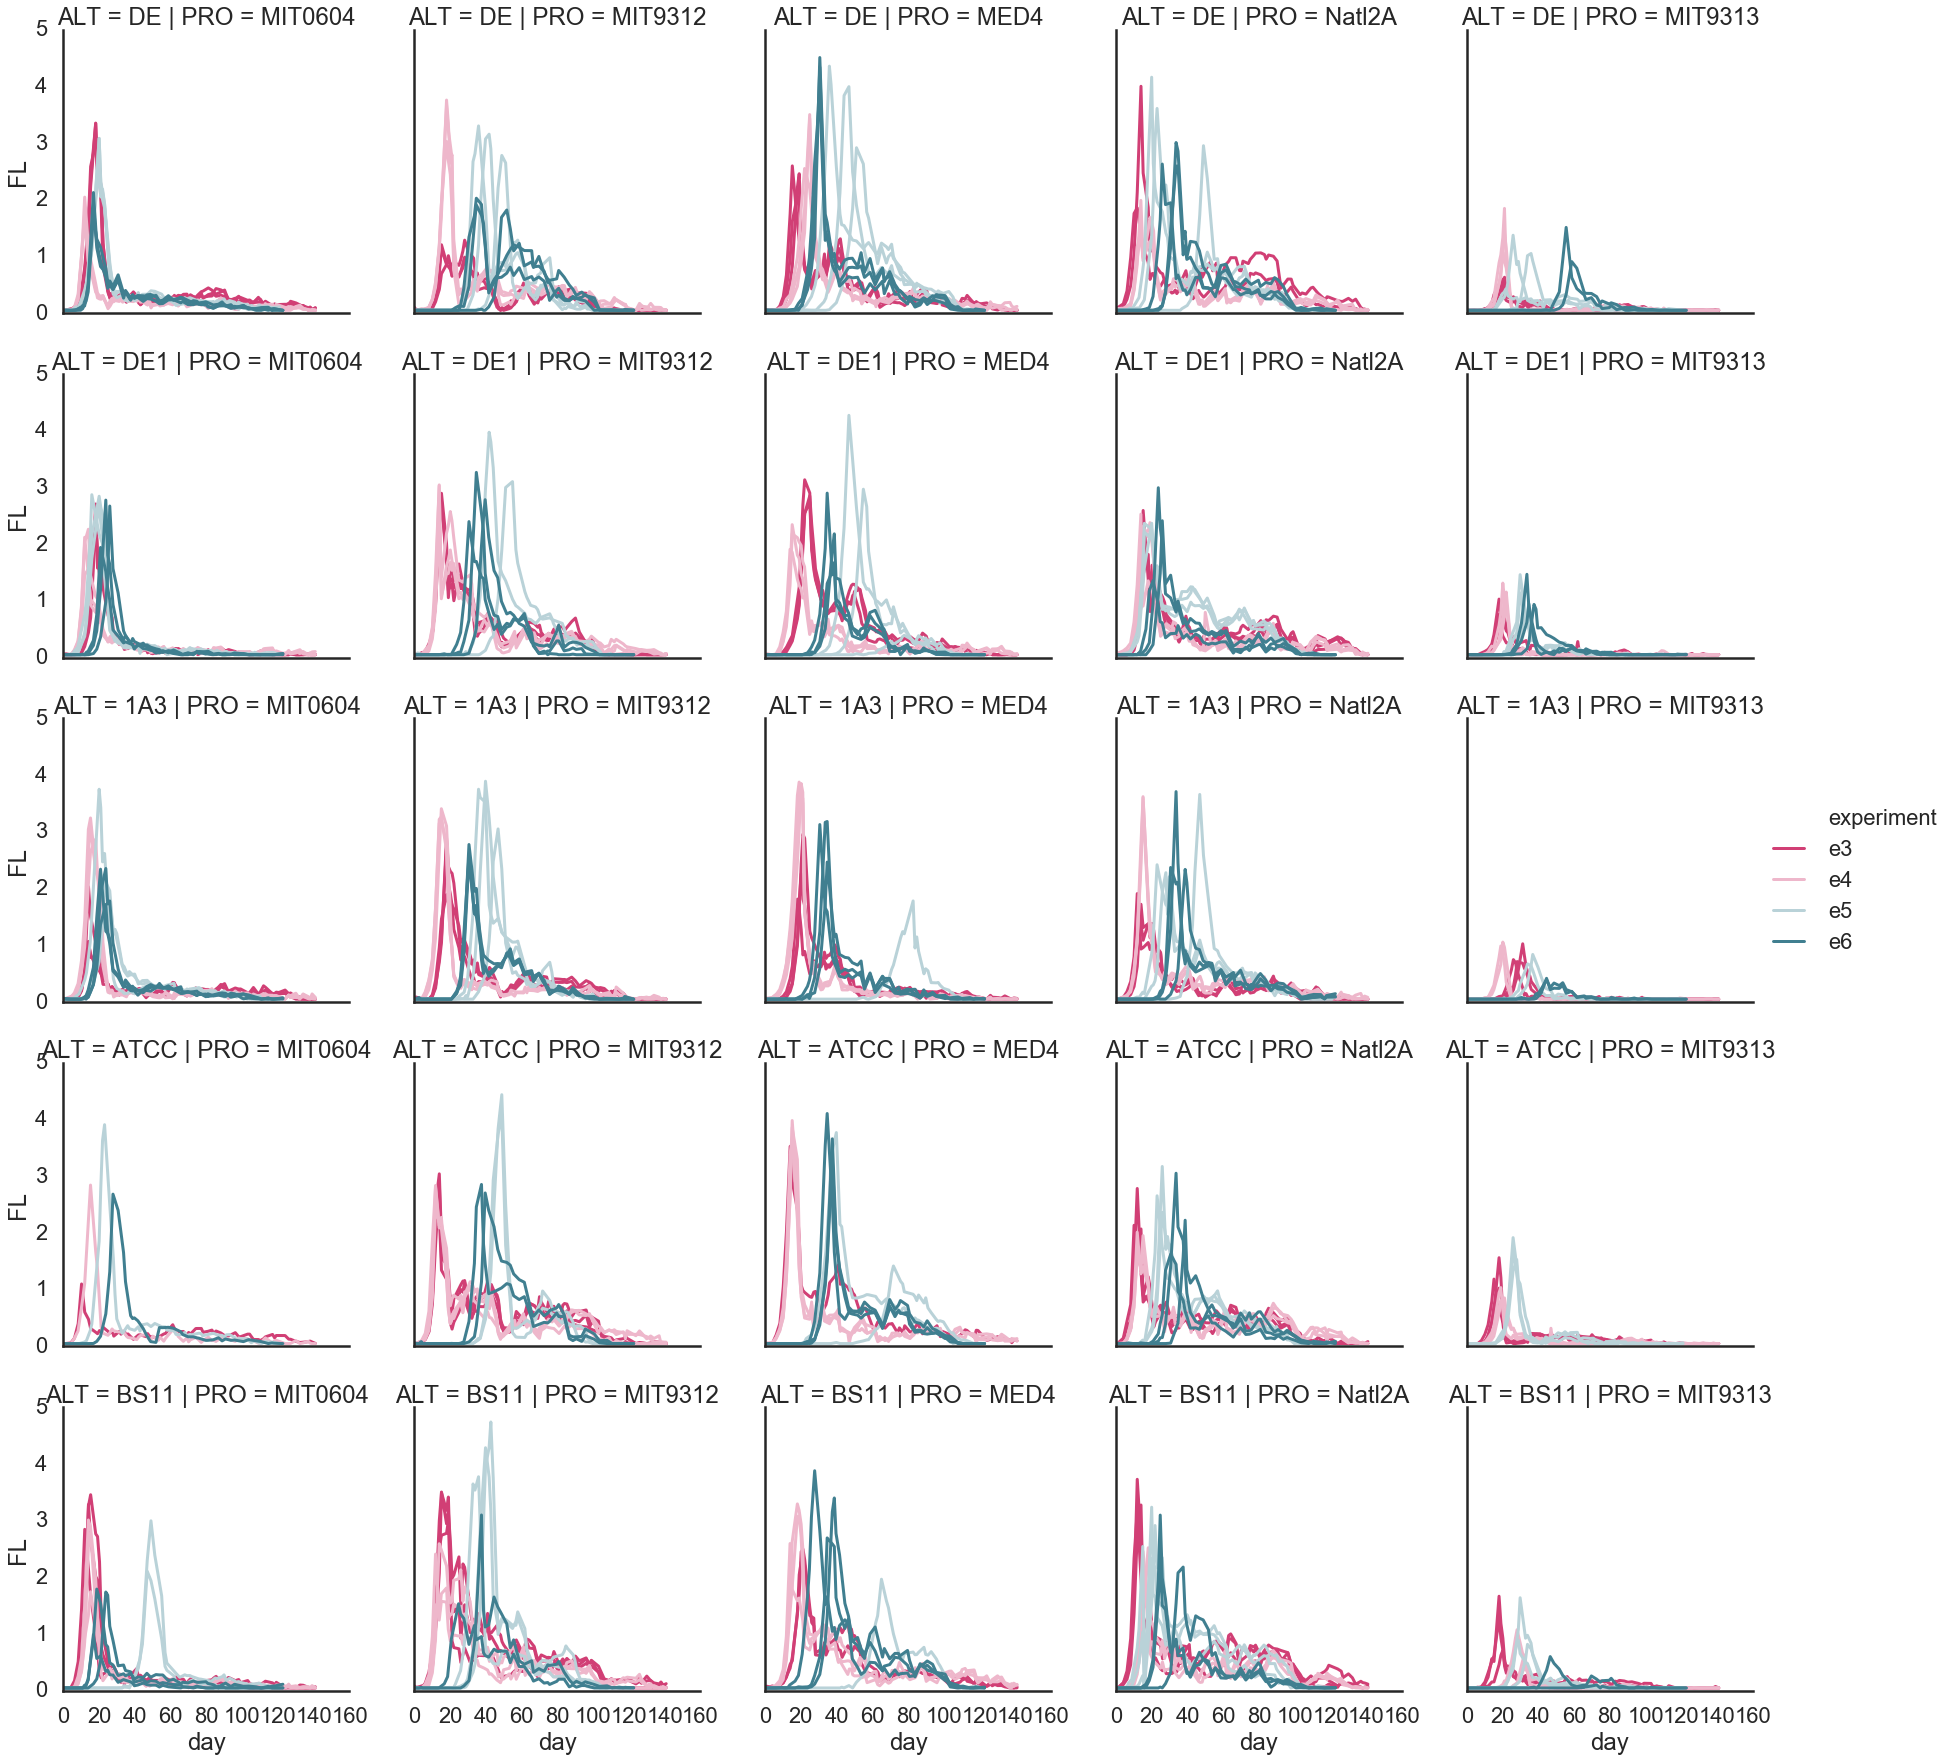

In [39]:
sns.relplot(data=dfc, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT', row_order=aorder, col_order=porder,
            x='day', y='FL', kind='line', hue='experiment', #legend=False, 
            hue_order=eorder, palette=epallete)

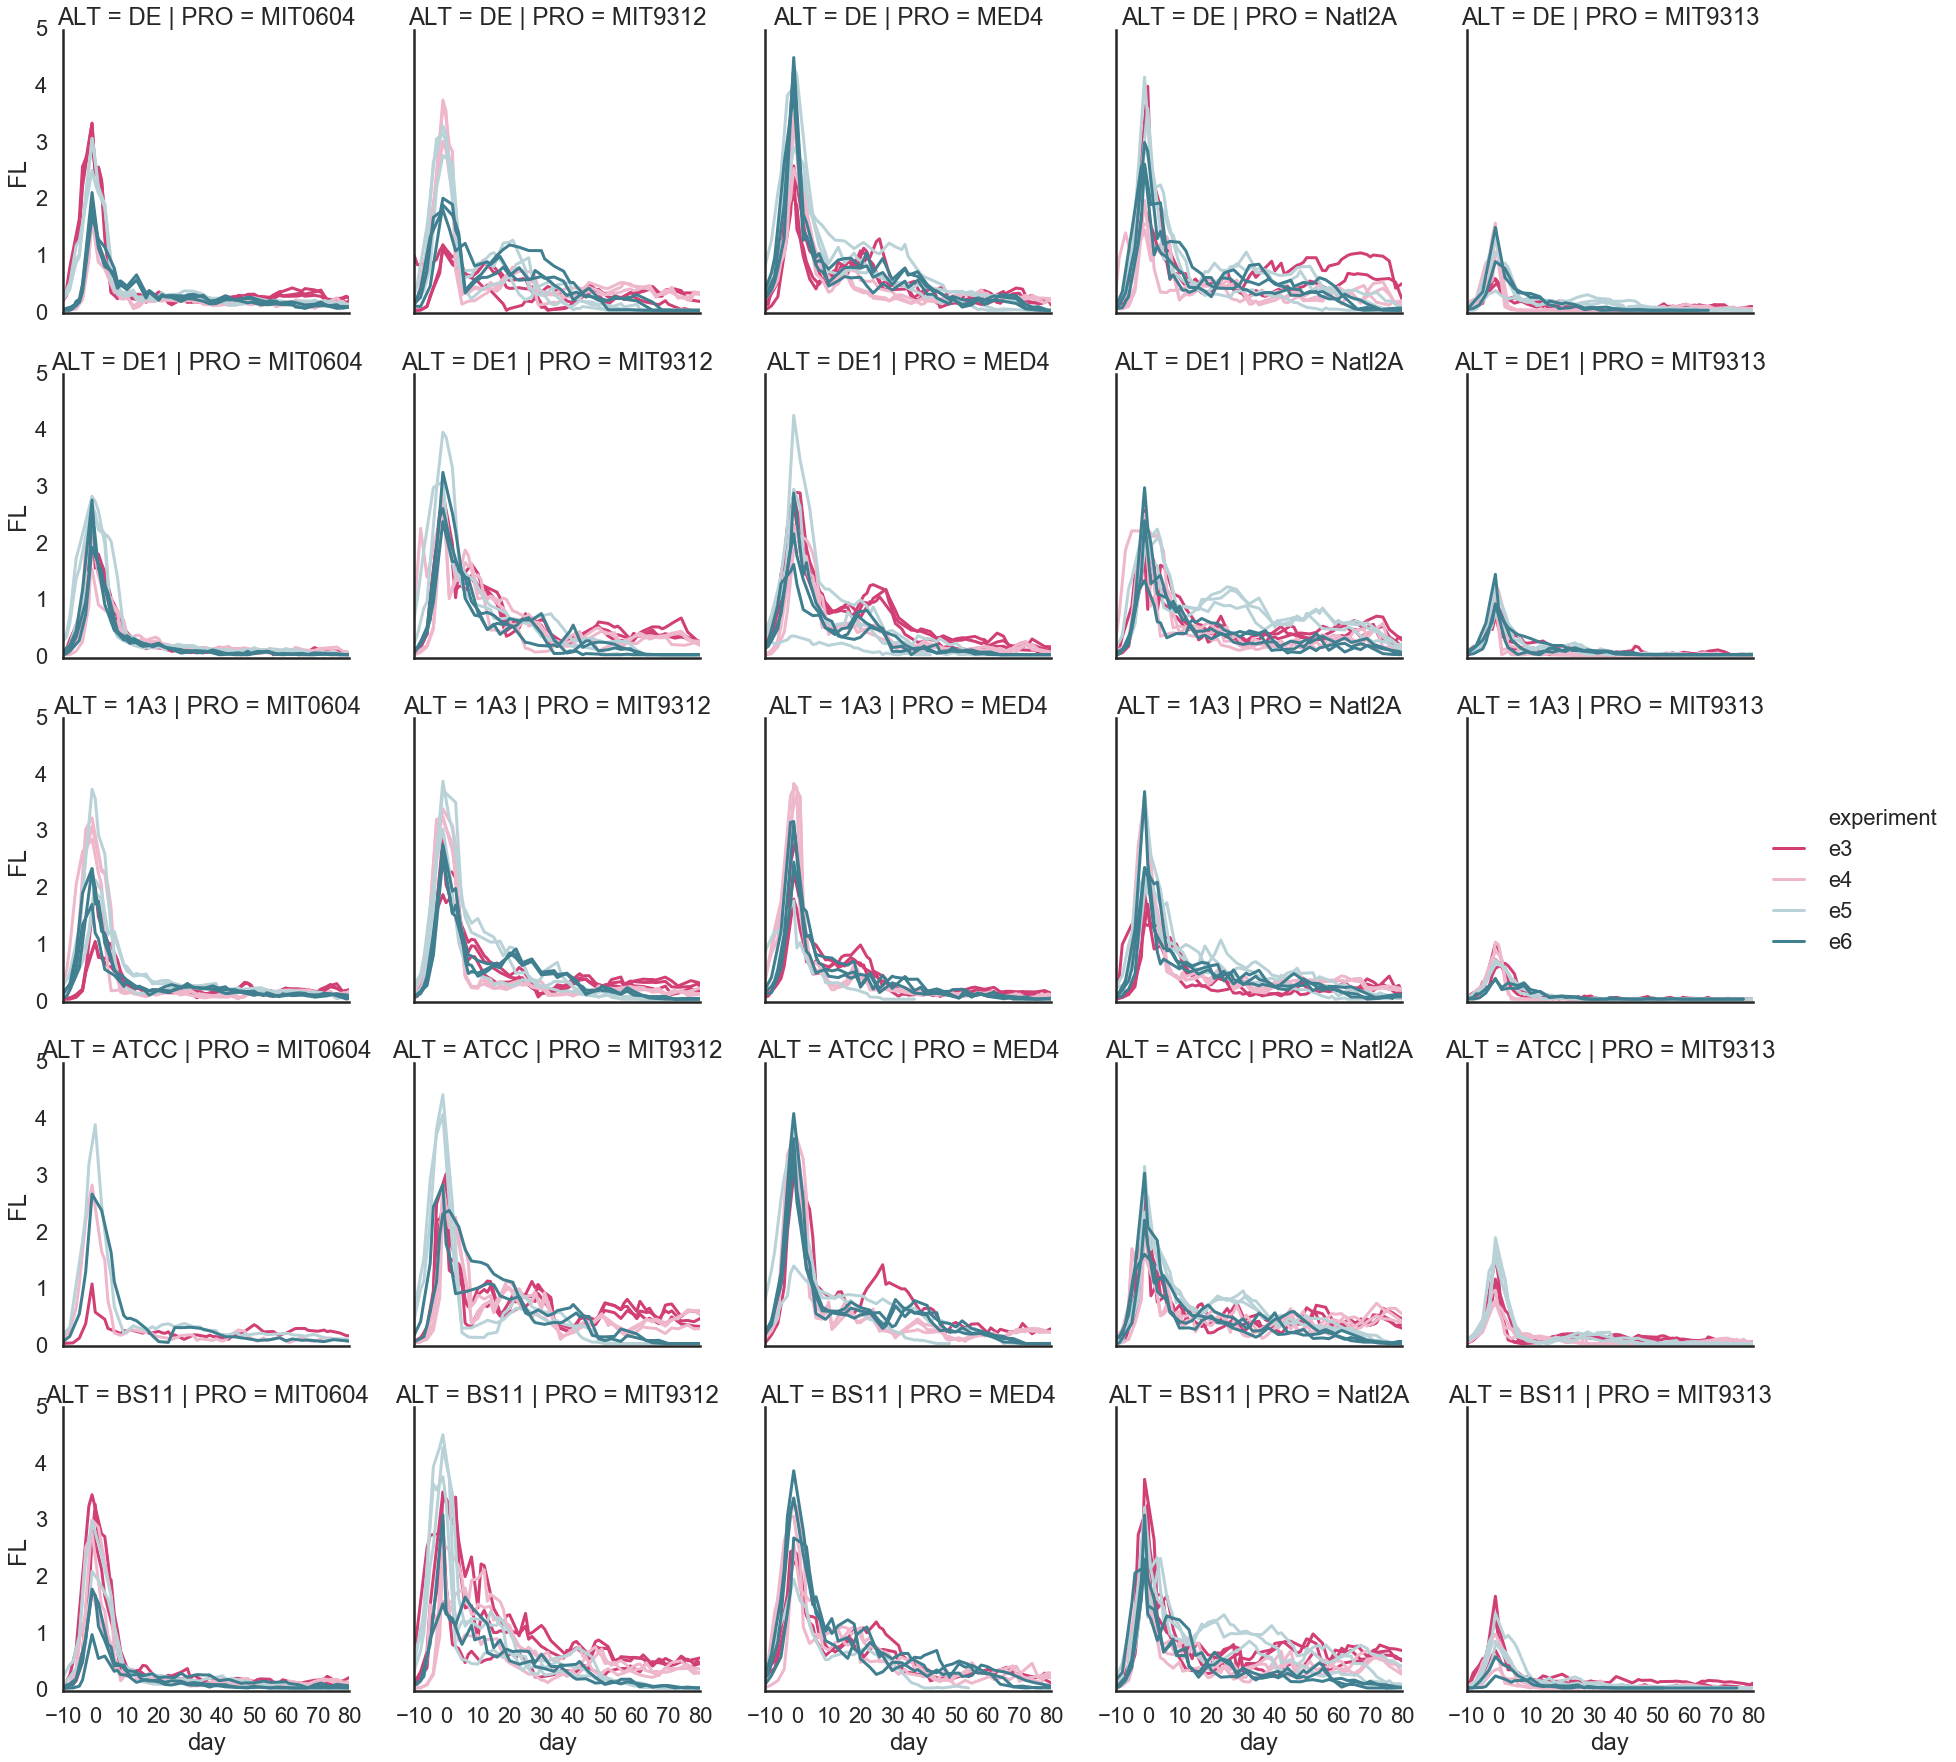

In [38]:
sns.relplot(data=ds, col='PRO', #row='experiment',
            estimator=None, units='experiment_sample', row='ALT',
            row_order=aorder, col_order=porder,
            x='day', y='FL', kind='line', hue='experiment', #legend=False, 
            hue_order=eorder, palette=epallete)

In [84]:
ds['decline'] = ds['FL']

In [54]:
ds34 = ds.loc[ds.experiment.isin(['e3', 'e4'])]
ds56 = ds.loc[ds.experiment.isin(['e5', 'e6'])]

In [55]:
ds34.head()

,experiment_sample,experiment,sample,PRO,ALT,culture,day,FL
9,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-10,0.299
10,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-9,0.381
11,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-8,0.693
12,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-7,0.959
13,"e3, 10A",e3,10A,MIT0604,DE,Co_Culture,-6,1.225


In [56]:
train34_df_orig, test34_df_orig = cp.split_train_test(ds34,test_size=0.4)
train56_df_orig, test56_df_orig = cp.split_train_test(ds56,test_size=0.4)

In [77]:
train34_df = cp.augment_training(train34_df_orig, noise_N=2, augment_x=False)
test34_df = test34_df_orig
train56_df = cp.augment_training(train56_df_orig, noise_N=2, augment_x=False)
test56_df = test56_df_orig

In [78]:
train34_df.shape, test34_df.shape, train56_df.shape, test56_df.shape, 

((458640, 10), (5187, 8), (403200, 10), (4691, 8))

In [69]:
train34_df.columns

Index(['experiment_sample', 'experiment', 'sample', 'PRO', 'ALT', 'culture',
       'day', 'FL', 'augment_name', 'experiment_sample_orig'],
      dtype='object')

In [80]:
stats34_list = []
y34_list = []
clf34_list = []
features34_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train34_df, test34_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=10,
               return_y=True)
stats34_list.extend(res)
y34_list.extend(_y_list)
clf34_list.extend(_clf_list)
features34_list.extend(_features_list)

PRO_FL
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0


In [81]:
stats56_list = []
y56_list = []
clf56_list = []
features56_list = []
res, _y_list, _clf_list, _features_list = cp.compare_models2(train56_df, test56_df, 
               value_col_list=['FL'], 
               y_col_list=['PRO'], 
               repetitions=10,
               return_y=True)
stats56_list.extend(res)
y56_list.extend(_y_list)
clf56_list.extend(_clf_list)
features56_list.extend(_features_list)

PRO_FL
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0
train score 1.0
oob score 1.0


In [82]:
stats56_df = pd.DataFrame.from_records(stats56_list)
stats34_df = pd.DataFrame.from_records(stats34_list)


In [86]:
stats56_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

,f1_test,accuracy_test,accuracy_train
2,0.766525,0.788462,1.0
6,0.766525,0.788462,1.0
1,0.751339,0.769231,1.0
8,0.738034,0.769231,1.0
0,0.736893,0.769231,1.0
5,0.734619,0.750000,1.0
7,0.720519,0.750000,1.0
4,0.706716,0.750000,1.0
9,0.705128,0.750000,1.0
3,0.688754,0.730769,1.0


In [87]:
stats34_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

,f1_test,accuracy_test,accuracy_train
3,0.929068,0.929825,1.0
5,0.928305,0.929825,1.0
9,0.928305,0.929825,1.0
0,0.928159,0.929825,1.0
4,0.925676,0.929825,1.0
7,0.925676,0.929825,1.0
1,0.909969,0.912281,1.0
2,0.892876,0.894737,1.0
8,0.888985,0.894737,1.0
6,0.888404,0.894737,1.0


In [90]:
idx34 = 3
y34_df =  y34_list[idx34]
clf34 = clf34_list[idx34]
features34 = features34_list[idx34]

In [91]:
y34_df.head()

,PRO_FL_y,PRO_FL_y_PRO,PRO_FL_y_pred,PRO_FL_y_pred_PRO,Type
experiment_sample,,,,,
"e3, 10A, FL_0.05_0_first",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e3, 10A, FL_0.05_0_last",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e3, 10A, FL_0.05_0_max",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e3, 10A, FL_0.05_0_mean",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e3, 10A, FL_0.05_0_median",MIT0604,MIT0604,MIT0604,MIT0604,Train


accuracy: 0.9298245614035088
              precision    recall  f1-score   support

        MED4       0.85      1.00      0.92        11
     MIT0604       0.83      1.00      0.91        10
     MIT9312       1.00      0.92      0.96        12
     MIT9313       1.00      1.00      1.00        11
      Natl2A       1.00      0.77      0.87        13

   micro avg       0.93      0.93      0.93        57
   macro avg       0.94      0.94      0.93        57
weighted avg       0.94      0.93      0.93        57



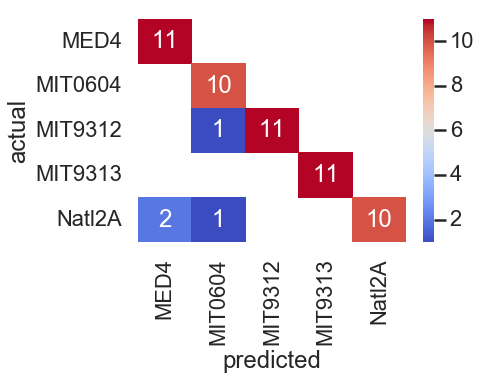

In [92]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df = y34_df
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')


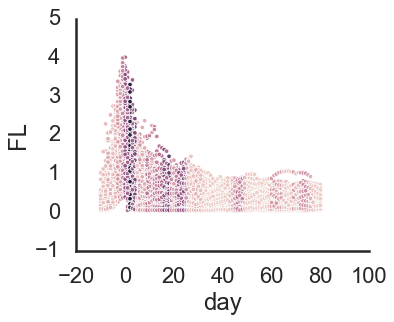

In [96]:
feature_importances34 = pd.DataFrame(clf34.feature_importances_,
                                   index = features34,
                                    columns=['importance'])
merge34df = ds34.merge(feature_importances34, left_on='day', right_index=True, how='left')
sns.relplot(data=merge34df, x='day', y='FL', hue='importance', legend=None, aspect=1.2)

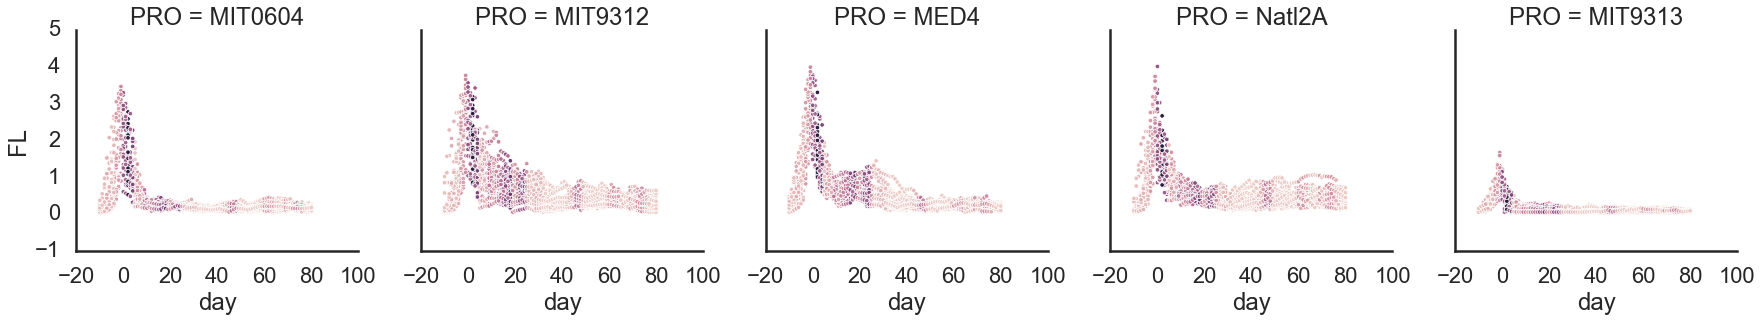

In [137]:
sns.relplot(data=merge34df, x='day', y='FL', hue='importance', legend=None, col='PRO', col_order=porder)

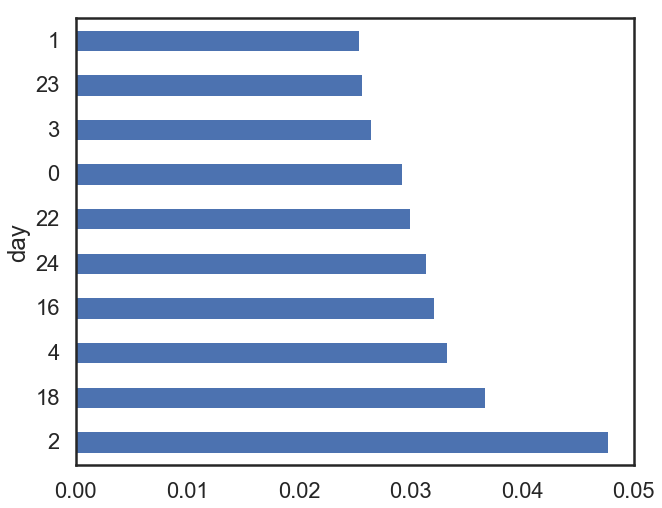

In [99]:
feature_importances34.nlargest(columns='importance',n=10).plot(kind='barh', legend=False,  figsize=(10,8) )

In [100]:
stats56_df.sort_values('f1_test', ascending=False).loc[:,['f1_test','accuracy_test', 'accuracy_train',  
       ]].head(10)

,f1_test,accuracy_test,accuracy_train
2,0.766525,0.788462,1.0
6,0.766525,0.788462,1.0
1,0.751339,0.769231,1.0
8,0.738034,0.769231,1.0
0,0.736893,0.769231,1.0
5,0.734619,0.750000,1.0
7,0.720519,0.750000,1.0
4,0.706716,0.750000,1.0
9,0.705128,0.750000,1.0
3,0.688754,0.730769,1.0


In [101]:
idx56 = 2
y56_df =  y56_list[idx56]
clf56 = clf56_list[idx56]
features56 = features56_list[idx56]

In [102]:
y56_df.head()

,PRO_FL_y,PRO_FL_y_PRO,PRO_FL_y_pred,PRO_FL_y_pred_PRO,Type
experiment_sample,,,,,
"e5, 10B, FL_0.05_0_first",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e5, 10B, FL_0.05_0_last",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e5, 10B, FL_0.05_0_max",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e5, 10B, FL_0.05_0_mean",MIT0604,MIT0604,MIT0604,MIT0604,Train
"e5, 10B, FL_0.05_0_median",MIT0604,MIT0604,MIT0604,MIT0604,Train


accuracy: 0.7884615384615384
              precision    recall  f1-score   support

        MED4       0.60      0.27      0.37        11
     MIT0604       1.00      1.00      1.00        10
     MIT9312       0.62      0.80      0.70        10
     MIT9313       1.00      1.00      1.00         9
      Natl2A       0.73      0.92      0.81        12

   micro avg       0.79      0.79      0.79        52
   macro avg       0.79      0.80      0.78        52
weighted avg       0.78      0.79      0.77        52



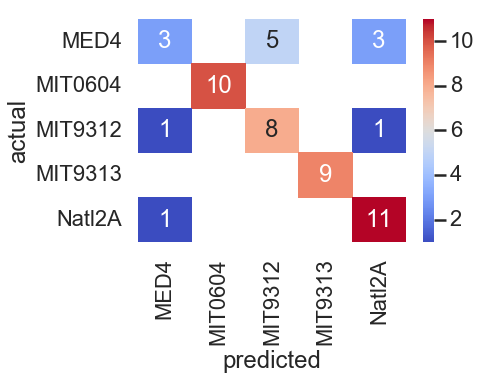

In [103]:
    from sklearn.metrics import classification_report, accuracy_score
    y_df = y56_df
    y_df['actual'] = y_df['PRO_FL_y']
    y_df['predicted'] = y_df['PRO_FL_y_pred']
    y_df = y_df.loc[y_df.Type == 'Test']
    t = y_df.pivot_table(index='actual', columns=['predicted'], 
                                                  values=['Type'], aggfunc='count')
    t.columns = t.columns.get_level_values(1)
    print(f"accuracy: {accuracy_score(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred'])}")
    print(classification_report(y_true=y_df['PRO_FL_y'], y_pred=y_df['PRO_FL_y_pred']))

    #forest_feature_importance(clf, X.columns)

    sns.heatmap(t, annot=True, cmap='coolwarm')


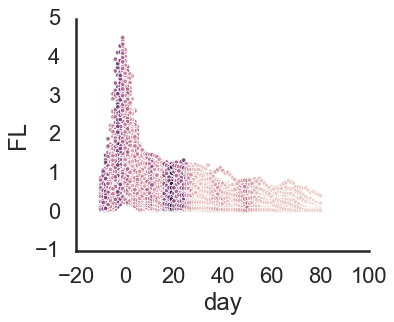

In [104]:
feature_importances56 = pd.DataFrame(clf56.feature_importances_,
                                   index = features56,
                                    columns=['importance'])
merge56df = ds56.merge(feature_importances56, left_on='day', right_index=True, how='left')
sns.relplot(data=merge56df, x='day', y='FL', hue='importance', legend=None, aspect=1.2)

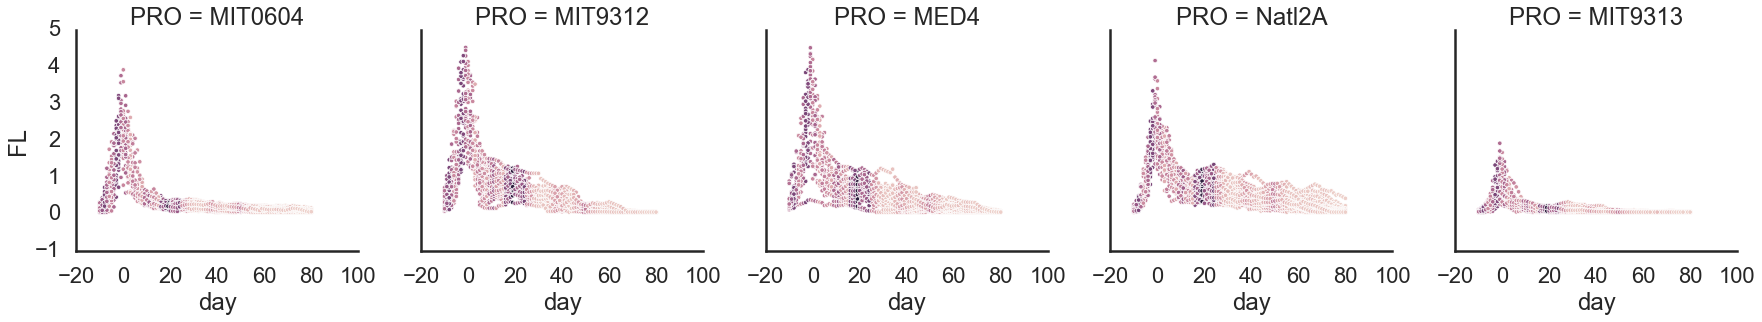

In [138]:
sns.relplot(data=merge56df, x='day', y='FL', hue='importance', legend=None, col='PRO', col_order=porder)

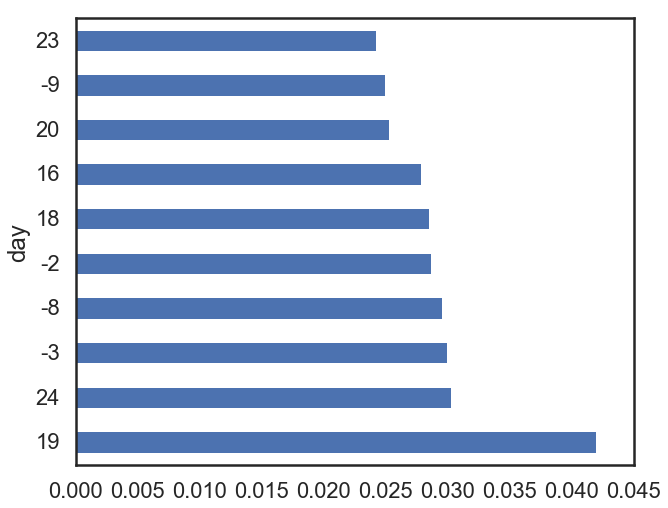

In [106]:
feature_importances56.nlargest(columns='importance',n=10).plot(kind='barh', legend=False,  figsize=(10,8) )

# cluster by decline

In [107]:
value_col = 'FL'

In [108]:
#dfe['sample_experiment'] = dfe['sample']+ ','+ dfe['experiment']
#sample_col = 'sample_experiment'
sample_col = 'experiment_sample'
#dfe_resample3 = cp.resample_df(dfe, value_col=value_col, period='5d')
X = cp.experiments2X(ds, value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds)
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']
dfpca = cp.run_pca(X=X, metadf=metadf, sample_col=sample_col)

Variance percent explained
 [0.56457792 0.1723785 ]


In [109]:
# Hl - MED4 , MIT9312, MIT0604
# LLIV MIT9313
# LLI Natl2A

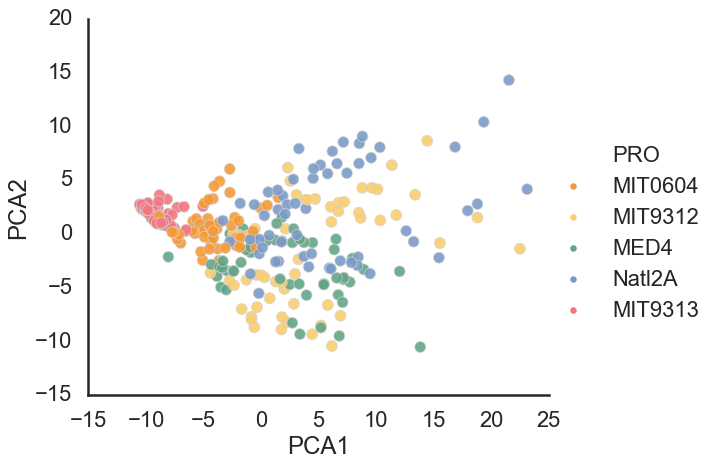

In [110]:
sns.set_style('white')

sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

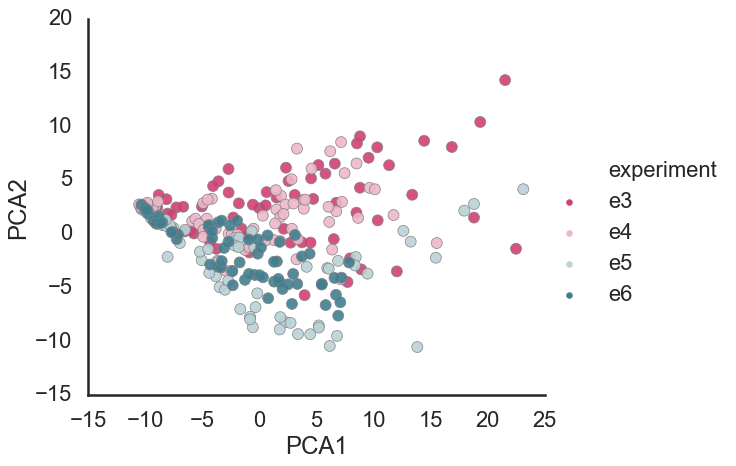

In [111]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='experiment', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=epallete, hue_order=eorder ,edgecolor='grey',
           )

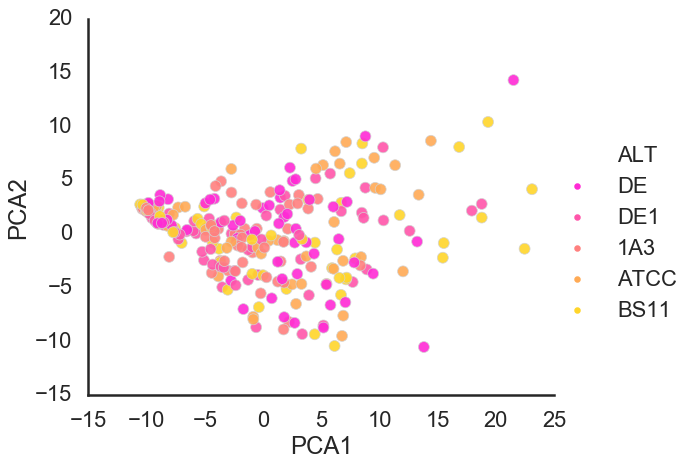

In [112]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', 
            #style='ALT',
            s=120, alpha=0.9, height=7, aspect=1.2,
            palette=apallete, hue_order=aorder, edgecolor='lightgrey',
           )

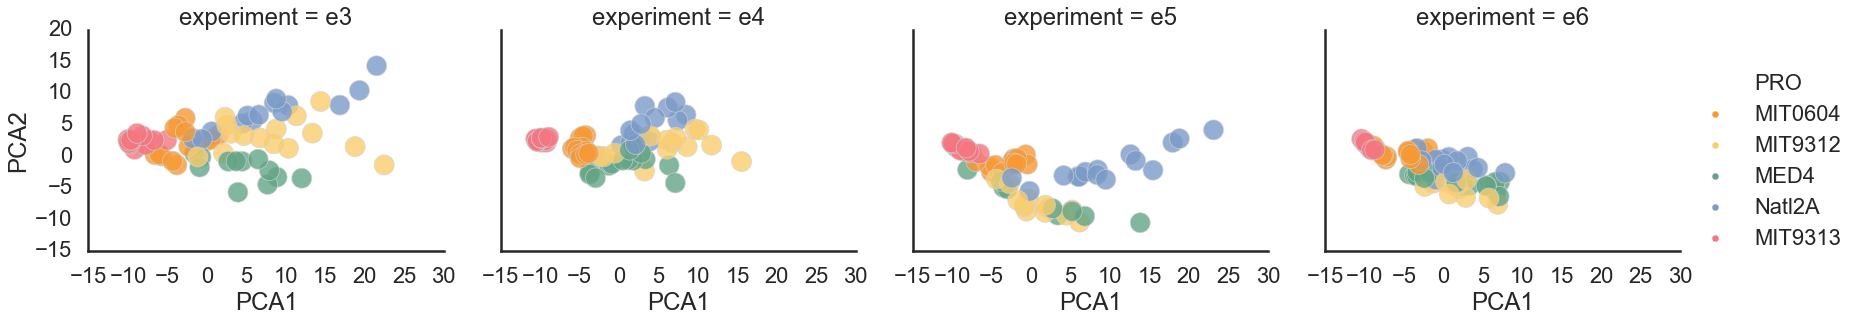

In [113]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='PRO', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            palette=ppallete, hue_order=porder ,edgecolor='lightgrey',
           )

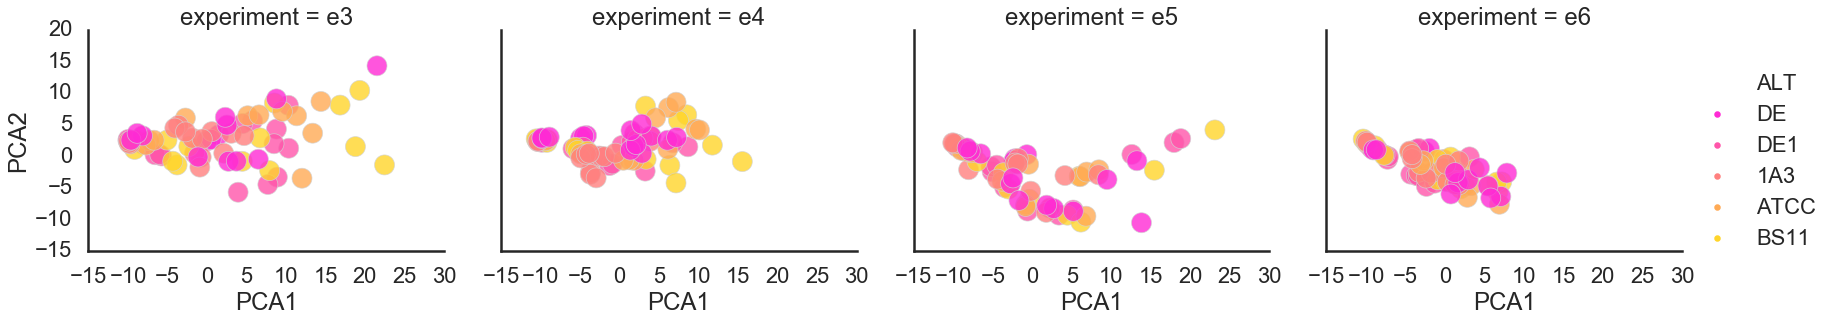

In [114]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', hue='ALT', col='experiment',
            #style='ALT',
            s=400, alpha=0.8, height=5, aspect=1.2,
            palette=apallete, hue_order=aorder ,edgecolor='lightgrey',
           )

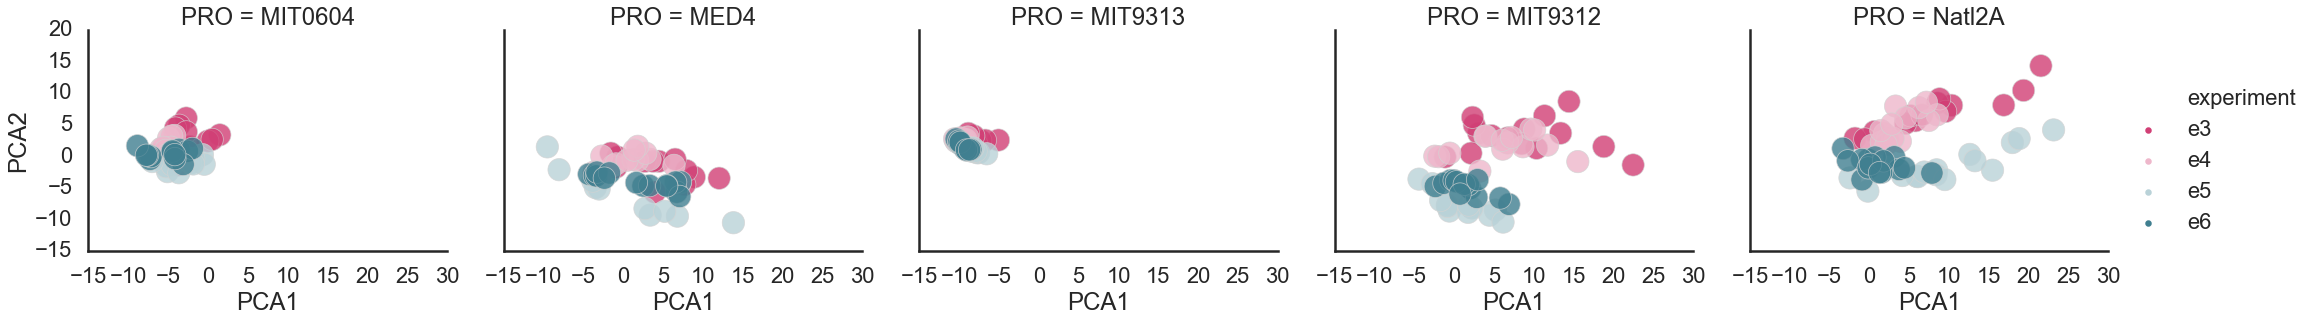

In [115]:
sns.relplot(data=dfpca, x='PCA1', y='PCA2', col='PRO', hue='experiment',
            #style='ALT',
            s=500, alpha=0.8, height=5, aspect=1.2,
            palette=epallete, hue_order=eorder, edgecolor='lightgrey',
           )

In [116]:
#metadf = cp.get_meta(df, meta_col=['experiment_sample', 'Mode','Sample', 'PRO', 'ALT'])
#metadf = metadf.loc[metadf.experiment_sample.isin(X1.index)]
metadf.index = metadf[sample_col]
col = 'PRO'
lut = dict(zip(metadf[col].unique(), sns.color_palette('Set2', n_colors=metadf[col].nunique())))
lut = dict(zip(porder, sns.color_palette(ppallete, n_colors=metadf[col].nunique())))
row_colors = metadf[col].map(lut)

col2 = 'experiment'
lut2 = dict(zip(metadf[col2].unique(), sns.color_palette('Set3', n_colors=metadf[col2].nunique())))
lut2 = dict(zip(eorder, sns.color_palette(epallete, n_colors=metadf[col2].nunique())))
row_colors2 = metadf[col2].map(lut2)

col3 = 'ALT'
lut3 = dict(zip(aorder, sns.color_palette(apallete, n_colors=metadf[col3].nunique())))
row_colors3 = metadf[col3].map(lut3)

#dfe_resample3 = cp.resample_df(dfe, value_col='decline', period='3d')
#X = cp.experiments2X(dfe_resample3, value_col='decline', cumsummode=False)


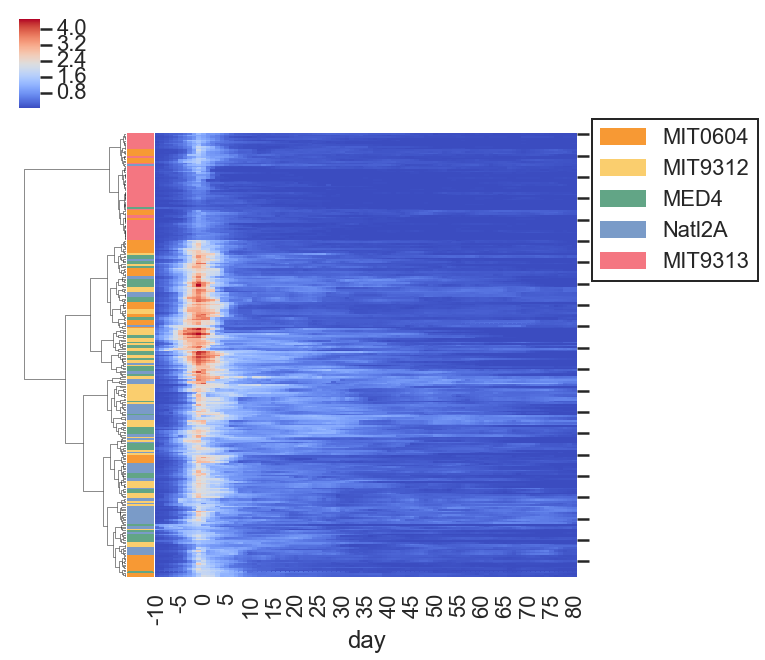

In [117]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

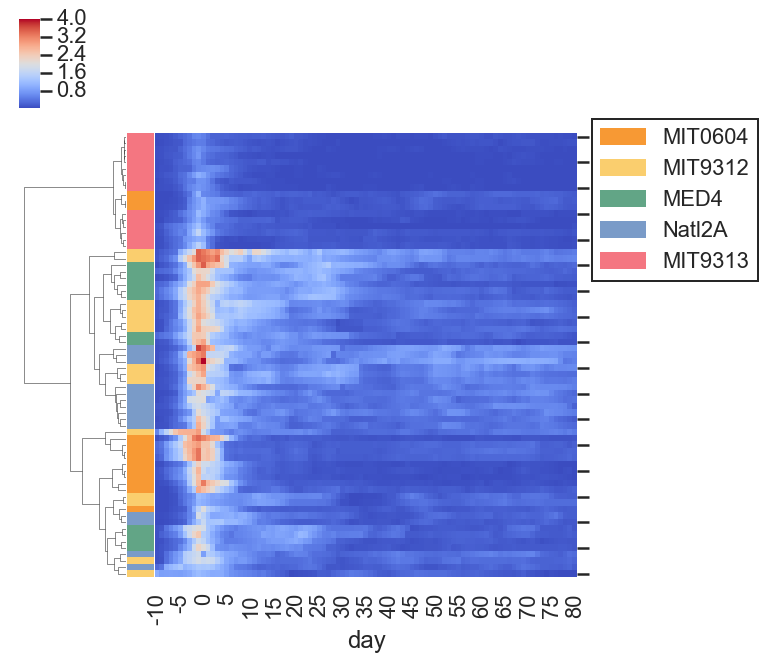

In [118]:
import matplotlib.patches as mpatches
X = cp.experiments2X(ds.loc[ds.experiment == 'e3'], value_col=value_col, cumsummode=False)
metadf = cp.get_meta(ds.loc[ds.experiment == 'e3'])
metadf['sample_experiment'] = metadf['sample']+ ','+ metadf['experiment']

g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                      # row_colors3
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut3.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

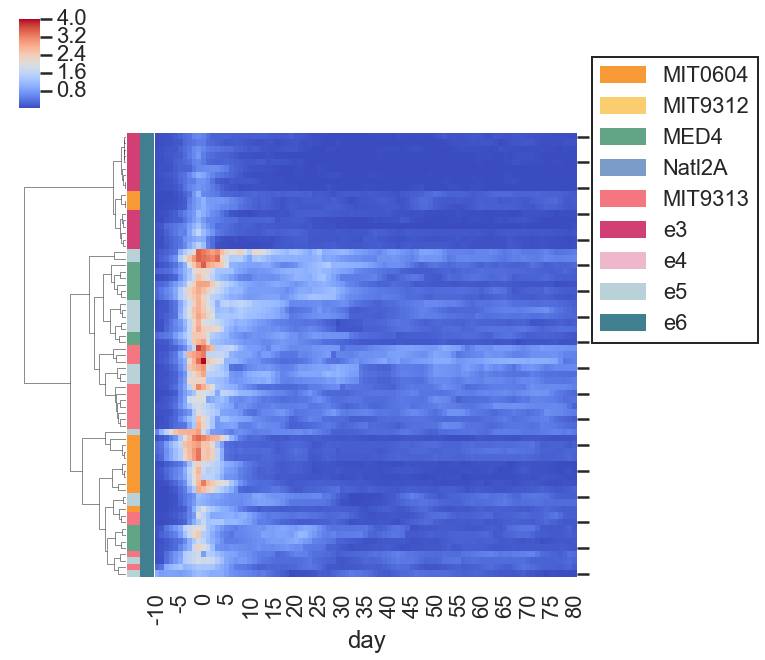

In [119]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       row_colors2
                              ], 
               method='ward'
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

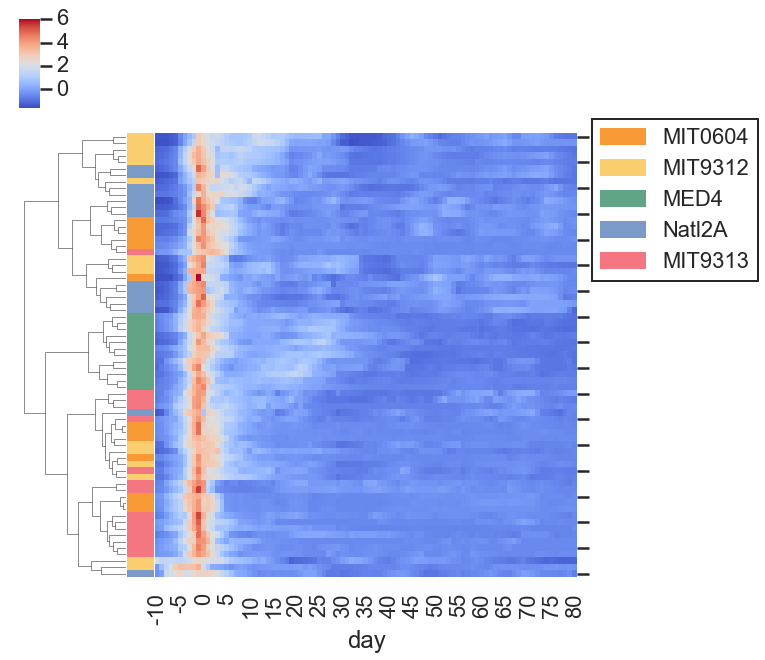

In [120]:
import matplotlib.patches as mpatches
g = sns.clustermap(data=X, col_cluster=False, #row_cluster=False,
                   cmap="coolwarm", 
                   row_colors=[row_colors, 
                       #row_colors2
                              ], 
               method='ward',
                   z_score=0, 
                  )
g.ax_heatmap.set_yticklabels('')
g.ax_heatmap.set_ylabel('')
legend_TN =  [mpatches.Patch(color=c, label=l) for l,c in lut.items()]
#legend_TN.extend([mpatches.Patch(color=c, label=l) for l,c in lut2.items()])

l2=g.ax_heatmap.legend(loc='center left',bbox_to_anchor=(1.01,0.85),handles=legend_TN,frameon=True)

# Analyze Features

In [121]:
from sklearn.linear_model import LogisticRegression


In [122]:
import tsfresh
from tsfresh.utilities.dataframe_functions import impute


In [123]:
def compute_corr(x, y):
    x = x.values.reshape(-1, 1)
    clf = LogisticRegression(solver='lbfgs', multi_class='multinomial').fit(x, y)
    return clf.score(x,y)

In [127]:
ds34c = cp.update_calculated_fields(ds34, group_col='experiment_sample', add_experiment_sample=False)
ds56c = cp.update_calculated_fields(ds56, group_col='experiment_sample', add_experiment_sample=False)

df_features34 = cp.generate_features(ds34c)
df_features56 = cp.generate_features(ds56c)

In [128]:
X_features34 = cp.features2X(df_features34)
metadf_features34 = cp.get_meta(df_features34, meta_col=['experiment_sample', 'experiment','sample', 'PRO', 'ALT', 'culture'], 
                     value_col='max')
metadf_features34.index = metadf_features34.experiment_sample
y34 = metadf_features34['PRO']

C:\Users\Osnat\Anaconda3\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [129]:
X_features56 = cp.features2X(df_features56)
metadf_features56 = cp.get_meta(df_features56, meta_col=['experiment_sample', 'experiment','sample', 'PRO', 'ALT', 'culture'], 
                     value_col='max')
metadf_features56.index = metadf_features56.experiment_sample
y56 = metadf_features56['PRO']

In [130]:
ts_f_features_df34 = tsfresh.extract_features(
    ds34c.loc[:, ['experiment_sample', 'FL', 'logFL', 'cumsumFL', 'cumsumlogFL', 'rateFL', 'ratelogFL', 'day']].fillna(0),
     column_id='experiment_sample', column_kind=None, 
     column_sort='day', 
    )


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [01:06<00:00,  2.10s/it]


In [131]:
ts_f_features_df56 = tsfresh.extract_features(
    ds56c.loc[:, ['experiment_sample', 'FL', 'logFL', 'cumsumFL', 'cumsumlogFL', 'rateFL', 'ratelogFL', 'day']].fillna(0),
     column_id='experiment_sample', column_kind=None, 
     column_sort='day', 
    )


Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 20/20 [00:57<00:00,  1.67s/it]


In [132]:
ts_f_features_df34 = impute(ts_f_features_df34)
ts_f_features_df56 = impute(ts_f_features_df56)

 'FL__fft_coefficient__coeff_46__attr_"angle"'
 'FL__fft_coefficient__coeff_46__attr_"imag"' ...
 'ratelogFL__fft_coefficient__coeff_99__attr_"angle"'
 'ratelogFL__fft_coefficient__coeff_99__attr_"imag"'
 'ratelogFL__fft_coefficient__coeff_99__attr_"real"'] did not have any finite values. Filling with zeros.
 'FL__fft_coefficient__coeff_46__attr_"angle"'
 'FL__fft_coefficient__coeff_46__attr_"imag"' ...
 'ratelogFL__fft_coefficient__coeff_99__attr_"angle"'
 'ratelogFL__fft_coefficient__coeff_99__attr_"imag"'
 'ratelogFL__fft_coefficient__coeff_99__attr_"real"'] did not have any finite values. Filling with zeros.


In [135]:
scores34 = {c : compute_corr(X_features34[c], y34) for c in X_features34.columns }
scores56 = {c : compute_corr(X_features56[c], y56) for c in X_features34.columns }

C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [136]:
scores34.update({f'ts_{c}' : compute_corr(ts_f_features_df34[c], y34) for c in ts_f_features_df34.columns })
scores56.update({f'ts_{c}' : compute_corr(ts_f_features_df56[c], y56) for c in ts_f_features_df56.columns })


C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Osnat\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", Convergenc

In [139]:
scores34_df = pd.Series(scores34)
scores56_df = pd.Series(scores56)

In [140]:
scores34_df.nlargest(20)

ts_logFL__quantile__q_0.8                                                        0.666667
ts_logFL__agg_linear_trend__f_agg_"mean"__chunk_len_50__attr_"intercept"         0.659574
ts_cumsumlogFL__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6      0.652482
ts_cumsumlogFL__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"slope"        0.645390
ts_cumsumlogFL__median                                                           0.645390
ts_cumsumlogFL__quantile__q_0.6                                                  0.645390
ts_cumsumlogFL__agg_linear_trend__f_agg_"min"__chunk_len_50__attr_"intercept"    0.638298
ts_cumsumlogFL__fft_coefficient__coeff_2__attr_"abs"                             0.638298
ts_cumsumFL__fft_coefficient__coeff_12__attr_"real"                              0.631206
ts_cumsumFL__fft_coefficient__coeff_36__attr_"imag"                              0.631206
ts_cumsumlogFL__cwt_coefficients__widths_(2, 5, 10, 20)__coeff_0__w_20           0.631206
ts_cumsuml

In [142]:
scores56_df.nlargest(20)

ts_logFL__range_count__max_1__min_-1                                           0.596899
ts_logFL__quantile__q_0.8                                                      0.589147
decline_log_intercept                                                          0.581395
ts_cumsumlogFL__quantile__q_0.6                                                0.581395
ts_cumsumFL__agg_linear_trend__f_agg_"max"__chunk_len_50__attr_"intercept"     0.565891
ts_cumsumlogFL__change_quantiles__f_agg_"mean"__isabs_False__qh_0.8__ql_0.6    0.565891
ts_cumsumlogFL__fft_aggregated__aggtype_"skew"                                 0.558140
ts_FL__fft_coefficient__coeff_1__attr_"abs"                                    0.550388
ts_cumsumlogFL__change_quantiles__f_agg_"mean"__isabs_True__qh_1.0__ql_0.6     0.550388
ts_cumsumlogFL__quantile__q_0.4                                                0.550388
ts_logFL__agg_linear_trend__f_agg_"min"__chunk_len_10__attr_"intercept"        0.550388
ts_cumsumlogFL__mean            